In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
import json
import glob

import time
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 12)

In [2]:
"""
load tinyimage net dataset and return 

Parameters:
----------
data_folder: directory to tiny imagenet
size: the pixel size for each image
batch_size: number of images per batch
num_works: set # of works simultaneously inputting data
----------

Returns:
----------
data_loader: returns pytorch object of the respective three datasets, 'train', 'val', and 'test'
dataset_sizes: returns dict of sizes
classes: returns list of all used in label IDs
----------

"""
def load_data(data_folder = '', size = 150, batch_size = 8, num_workers = 8):
    data_transforms = {
        'train': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    }

    imagenets = {
        'train': ImageFolder(data_folder + '/train', transform=data_transforms['train']),
        'val': ImageFolder(data_folder + '/val', transform=data_transforms['val']),
        'test': ImageFolder(data_folder + '/test', transform=data_transforms['test'])
    }

    data_loader = {
        x: torch.utils.data.DataLoader(imagenets[x],
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=num_workers) for x in ['train', 'val', 'test']
    }
    dataset_sizes = {x: len(imagenets[x]) for x in ['train', 'val', 'test']}
    print('Datasets Loaded')
    classes = imagenets['train'].classes
    
    return data_loader, dataset_sizes, classes

In [3]:
"""
load label IDs and match them with their description

Parameters:
----------
label_folder: directory to words.txt within the tiny imagenet directory
----------

Returns:
----------
labels_list: returns a list of just the descriptions of all IDs
labels_dict: returns dict of the list above, but matched with its ID
----------

"""
def load_labels(label_folder = ''):
    f = open(label_folder, "r")
    labels_dict = {}
    labels_list = []
    for line in f:
        split = line.split(maxsplit=1)
        split[1] = split[1][:-1]
        label_id, label = split[0], split[1]
        labels_dict[label_id] = label.split(',')[0]
        labels_list.append(split[1])
    print("Labels Loaded")
    return labels_list, labels_dict

In [4]:
"""
Get label description based on index. Index number represents where it lies in 'classes' array. 
Using a dict we can return a description rather than an ID.

Parameters:
----------
x: index in classes array, to be transformed to description
----------

Returns:
----------
label: returns a string of more than 1 word replacing the ID
----------

"""
def get_label(x):
    label = labels_dict[classes[x]]
    return label

In [5]:
"""
Denormalize our images due to our preprocessing early, and convert them to numpy arrays to be viewed using matplotlib.

Parameters:
----------
img: tensor object representing the image
title: caption/title of that specific image
----------
"""
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #Pause is necessary to display images correctly

In [6]:
data,sizes,classes = load_data('tinyimage10')
data

Datasets Loaded


{'train': <torch.utils.data.dataloader.DataLoader at 0x22d388e14e0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x22d388e13c8>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x22d3f00d438>}

In [7]:
labels_list, labels_dict = load_labels("tinyimage10\\words.txt")
print(labels_list[1:4])

Labels Loaded
['physical entity', 'abstraction, abstract entity', 'thing']


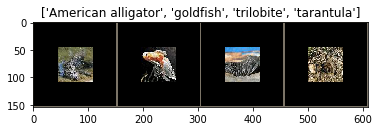

In [8]:
# Get a batch of training data
inputs, labels_id = next(iter(data['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4], nrow = 4)

imshow(out, title=[get_label(x) for x in labels_id[0:4]])

In [9]:
"""
Reproduced AlexNet model.
"""
class AlexNet(nn.Module):
    
    def __init__(self, num_classes=200):
        
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
            
           nn.Conv2d(64, 192, kernel_size=5, padding=2),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
            
           nn.Conv2d(192, 384, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
        
           nn.Conv2d(384, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
            
           nn.Conv2d(256, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.fc = nn.Sequential(
           nn.Dropout(),
           nn.Linear(256*6*6, 4096),
           nn.ReLU(inplace=True),
           
           nn.Dropout(),
           nn.Linear(4096, 4096),
           nn.ReLU(inplace=True),
         
           nn.Linear(4096, num_classes),
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.fc(x)   
        return x
    
model = AlexNet()
model

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU

In [15]:
"""
Train reproduced AlexNet model based on inputs and parameters. Returns the model and time taken per run. 
Adds metric values to tensorboard Writer file to be viewed.

Parameters:
----------
model: model to use for training
data_loader: pytorch object of the respective three datasets, 'train', 'val', and 'test'
loss_func: loss function, Cross Entropy Loss used in this case
scheduler: scheduler for adjusting learning rate
optimizer: optimizer function (only SGD available at the moment)
num_epochs: number of epochs per run
momentum: used to calculate weight decay
step_size: ...
gamma: gamma value
print_freq: console printing frequency
----------

Returns:
----------
model: returns the model back
t: returns time taken to run function in minutes
----------

"""
def train(model, data_loader, loss_func, scheduler, optimizer, num_epochs=20, 
          lr=0.005, momentum = 0.9, step_size=30, gamma=0.1,print_freq=200):
    
    since = time.time()

    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    progress = []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # You perform validation test after every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0 
                
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero accumulated gradients
                optimizer.zero_grad()
                
                # During train phase we want to remember history for grads
                # and during val we do not want history of grads
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if i%print_freq == 0:
                        train_batch_loss.append(loss.item())
                        print('Epoch {}: {}/{} step in progress'.format(epoch+1, i, len(data_loader['train'])))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_epoch_loss.append((epoch_loss, epoch_acc))
                writer.add_scalar('val acc',
                epoch_acc,
                epoch)
                writer.add_scalar('val loss',
                epoch_loss,
                epoch)
                scheduler.step(loss.item())
            else:
                train_epoch_loss.append((epoch_loss, epoch_acc))
                writer.add_scalar('train acc',
                epoch_acc,
                epoch)
                writer.add_scalar('train loss',
                epoch_loss,
                epoch)
                scheduler.step(loss.item())
                scheduler.step(loss.item())
                
            progress.append([epoch_loss, epoch_acc.item()])
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    t = np.float(time_elapsed/60)
    
    return model, t

In [16]:
"""
Calculate accuracy of model using an input to test on. 
Available option to show accuracy of each label, rather than total accuracy.

Parameters:
----------
data: pytorch object dataset (ex: data['train'] or data['test'])
labels_acc: True or False, show labels accuracy instead of total accuracy
----------

Returns:
----------
acc: accuracy (correct / total)
----------
"""
def calc_acc(data, labels_acc = False):
    if(labels_acc == False):
        # Get test accuracy.
        correct = 0
        total = 0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(data):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        print('Accuracy of the network on %2d images: %d %%' % (len(preds),
            100 * correct / total))
        acc = correct / total
        return acc
    
    if(labels_acc == True):
        # Get test accuracy for each class.
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(data):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(10):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
            for i in range(10):
                print('Accuracy of %5s : %2d %%' % (
                    labels_dict[classes[i]], 100 * class_correct[i] / class_total[i]))

In [77]:
from IPython.display import display, clear_output
# We train everything on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

device:  cuda


In [107]:
params = {
    'batch_size' : [12],
    'learning_rate' : [ 0.0001, 0.001, 0.005],
    'momentum' : [0.9, 0.5],
    'gamma' : [0.1, 0.01],
    'optimizer' : ['sgd'],
    'epoch' : 35
}

In [17]:
"""
Gridsearch across parameters to pick out best hyperparameters for this subset of data. Using previous functions to produce results.
Saves information, metrics, and parameters in DataFrame.

"""


acc = []
inputs = []

trials = len(params['batch_size']) * len(params['lr']) * len(params['momentum']) * len(params['gamma'])
trial = 0

epoch = params['epoch'][0]

for i, batch in enumerate(params['batch_size']):
    for j, lr in enumerate(params['learning_rate']):
        for k, mom in enumerate(params['momentum']):
            for l, gamma in enumerate(params['gamma']):
                for m, opt in enumerate(params['optimizer']):

                    #print('', end='\r')
                    clear_output(wait=True)
                    print('Trial {}/{}'.format(trial+1, trials))

                    trial += 1
                    data,sizes,classes = load_data('tinyimage10', batch_size = batch)
                    labels_list, labels_dict = load_labels("tinyimage10\\words.txt")

                    model = AlexNet()
                    file = 'runs/AlexNet_experiment_' + str(i) + str(j) + str(k)  + str(l)
                    
                    writer = SummaryWriter(file)
                    print(file)

                    if(opt == 'sgd'):
                    # Cross entropy loss takes the logits directly, so we don't need to apply softmax in our CNN
                        loss_func = nn.CrossEntropyLoss()
                        optimizer = optim.SGD(model.parameters(), lr=lr, momentum = mom)
                        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30,gamma=gamma)

                    model = model.to(device)

                    
                    m, t = train(model, data, loss_func, scheduler, optimizer, num_epochs=epoch, lr=lr, momentum = mom, step_size=30, gamma=gamma)
                    inputs.append([file, batch, lr, mom, gamma,opt,t])
                    
                    train_acc = calc_acc(data['train'], labels_acc = False)
                    val_acc = calc_acc(data['val'], labels_acc = False)
                    test_acc = calc_acc(data['test'], labels_acc = False)
                    acc.append([train_acc, val_acc, test_acc])



results = pd.concat([pd.DataFrame(inputs), pd.DataFrame(acc)], axis=1)
results.columns = ['file','batch_size', "learning_rate", "momentum", 'gamma','optimizer','time(m)','train_acc','val_acc','test_acc']

Trial 12/12
Datasets Loaded
Labels Loaded
runs/AlexNet_experiment_0211
Epoch 1/35
---------------
Epoch 1: 0/334 step in progress
Epoch 1: 200/334 step in progress
train Loss: 2.8904 Acc: 0.0990
Epoch 1: 0/334 step in progress
val Loss: 2.4170 Acc: 0.1000

Epoch 2/35
---------------
Epoch 2: 0/334 step in progress
Epoch 2: 200/334 step in progress
train Loss: 2.3780 Acc: 0.1025
Epoch 2: 0/334 step in progress
val Loss: 2.4286 Acc: 0.1000

Epoch 3/35
---------------
Epoch 3: 0/334 step in progress
Epoch 3: 200/334 step in progress
train Loss: 2.3629 Acc: 0.1028
Epoch 3: 0/334 step in progress
val Loss: 2.3948 Acc: 0.1000

Epoch 4/35
---------------
Epoch 4: 0/334 step in progress
Epoch 4: 200/334 step in progress
train Loss: 2.3460 Acc: 0.1038
Epoch 4: 0/334 step in progress
val Loss: 2.3137 Acc: 0.1120

Epoch 5/35
---------------
Epoch 5: 0/334 step in progress
Epoch 5: 200/334 step in progress
train Loss: 2.2992 Acc: 0.1265
Epoch 5: 0/334 step in progress
val Loss: 2.2725 Acc: 0.1380


,file,batch_size,learning_rate,momentum,gamma,optimizer,time(m),train_acc,val_acc,test_acc
0,runs/AlexNet_experiment_0000,12,0.0001,0.9,0.10,sgd,11.339211,0.16550,0.164,0.166
1,runs/AlexNet_experiment_0001,12,0.0001,0.9,0.01,sgd,10.766934,0.16000,0.154,0.154
2,runs/AlexNet_experiment_0010,12,0.0001,0.5,0.10,sgd,10.802704,0.10650,0.110,0.112
3,runs/AlexNet_experiment_0011,12,0.0001,0.5,0.01,sgd,10.881917,0.10325,0.098,0.098
4,runs/AlexNet_experiment_0100,12,0.0010,0.9,0.10,sgd,10.824979,0.77850,0.538,0.546
5,runs/AlexNet_experiment_0101,12,0.0010,0.9,0.01,sgd,10.823393,0.72800,0.518,0.534
6,runs/AlexNet_experiment_0110,12,0.0010,0.5,0.10,sgd,11.056019,0.31725,0.314,0.276
7,runs/AlexNet_experiment_0111,12,0.0010,0.5,0.01,sgd,11.018509,0.32650,0.316,0.304
8,runs/AlexNet_experiment_0200,12,0.0050,0.9,0.10,sgd,11.177425,0.68500,0.526,0.534
9,runs/AlexNet_experiment_0201,12,0.0050,0.9,0.01,sgd,10.675909,0.70275,0.508,0.518


In [38]:
results = results.sort_values(by='test_acc', ascending=False).reset_index(drop=True)
best = results.iloc[0,]
results

,file,batch_size,learning_rate,momentum,gamma,optimizer,time(m),train_acc,val_acc,test_acc
0,runs/AlexNet_experiment_0100,12,0.0010,0.9,0.10,sgd,10.824979,0.77850,0.538,0.546
1,runs/AlexNet_experiment_0101,12,0.0010,0.9,0.01,sgd,10.823393,0.72800,0.518,0.534
2,runs/AlexNet_experiment_0200,12,0.0050,0.9,0.10,sgd,11.177425,0.68500,0.526,0.534
3,runs/AlexNet_experiment_0211,12,0.0050,0.5,0.01,sgd,10.594885,0.73750,0.552,0.534
4,runs/AlexNet_experiment_0201,12,0.0050,0.9,0.01,sgd,10.675909,0.70275,0.508,0.518
5,runs/AlexNet_experiment_0210,12,0.0050,0.5,0.10,sgd,10.631684,0.72800,0.520,0.502
6,runs/AlexNet_experiment_0111,12,0.0010,0.5,0.01,sgd,11.018509,0.32650,0.316,0.304
7,runs/AlexNet_experiment_0110,12,0.0010,0.5,0.10,sgd,11.056019,0.31725,0.314,0.276
8,runs/AlexNet_experiment_0000,12,0.0001,0.9,0.10,sgd,11.339211,0.16550,0.164,0.166
9,runs/AlexNet_experiment_0001,12,0.0001,0.9,0.01,sgd,10.766934,0.16000,0.154,0.154


In [71]:
best

file             runs/AlexNet_experiment_0100
batch_size                                 12
learning_rate                           0.001
momentum                                  0.9
gamma                                     0.1
optimizer                                 sgd
time(m)                                10.825
train_acc                              0.7785
val_acc                                 0.538
test_acc                                0.546
Name: 0, dtype: object

In [70]:
params

{'batch_size': [12],
 'learning_rate': [0.0001, 0.001, 0.005],
 'momentum': [0.9, 0.5],
 'gamma': [0.1, 0.01],
 'optimizer': ['sgd'],
 'epoch': [35]}

In [108]:
best_params = params
for i ,(key, value) in enumerate(params.items()):
    if(key in best):
        best_params[key] = best[key]
best_params

{'batch_size': 12,
 'learning_rate': 0.001,
 'momentum': 0.9,
 'gamma': 0.1,
 'optimizer': 'sgd',
 'epoch': 35}

In [111]:
batch = int(best_params['batch_size'])
lr = float(best_params['learning_rate'])
mom = float(best_params['momentum'])
gamma = float(best_params['gamma'])
epoch = best_params['epoch']

print('batch_size: {}, learning_rate: {}, momentum: {}, gamma: {}, epochs: {}'.format(batch,lr,mom,gamma,epoch))

data,sizes,classes = load_data('tinyimage10', batch_size = batch)
labels_list, labels_dict = load_labels("tinyimage10\\words.txt")

model = AlexNet()
file = 'runs/AlexNet_experiment_best'

writer = SummaryWriter(file)
print(file)


# Cross entropy loss takes the logits directly, so we don't need to apply softmax in our CNN
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = mom)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30,gamma=gamma)

model = model.to(device)


m, t = train(model, data, loss_func, scheduler, optimizer, num_epochs=epoch, lr=lr, momentum = mom, step_size=30, gamma=gamma)

batch_size: 12, learning_rate: 0.001, momentum: 0.9, gamma: 0.1, epochs: 35
Datasets Loaded
Labels Loaded
runs/AlexNet_experiment_best
Epoch 1/35
---------------
Epoch 1: 0/334 step in progress
Epoch 1: 200/334 step in progress
train Loss: 3.1651 Acc: 0.0995
Epoch 1: 0/334 step in progress
val Loss: 2.4213 Acc: 0.1000

Epoch 2/35
---------------
Epoch 2: 0/334 step in progress
Epoch 2: 200/334 step in progress
train Loss: 2.3918 Acc: 0.0975
Epoch 2: 0/334 step in progress
val Loss: 2.3817 Acc: 0.1000

Epoch 3/35
---------------
Epoch 3: 0/334 step in progress
Epoch 3: 200/334 step in progress
train Loss: 2.3578 Acc: 0.1008
Epoch 3: 0/334 step in progress
val Loss: 2.3494 Acc: 0.1360

Epoch 4/35
---------------
Epoch 4: 0/334 step in progress
Epoch 4: 200/334 step in progress
train Loss: 2.3471 Acc: 0.0975
Epoch 4: 0/334 step in progress
val Loss: 2.3121 Acc: 0.1100

Epoch 5/35
---------------
Epoch 5: 0/334 step in progress
Epoch 5: 200/334 step in progress
train Loss: 2.3018 Acc: 0.12

In [121]:
results.to_csv('results.csv', index = None)

In [122]:
temp = pd.read_csv('results.csv')
temp

,file,batch_size,learning_rate,momentum,gamma,optimizer,time(m),train_acc,val_acc,test_acc
0,runs/AlexNet_experiment_0100,12,0.0010,0.9,0.10,sgd,10.824979,0.77850,0.538,0.546
1,runs/AlexNet_experiment_0101,12,0.0010,0.9,0.01,sgd,10.823393,0.72800,0.518,0.534
2,runs/AlexNet_experiment_0200,12,0.0050,0.9,0.10,sgd,11.177425,0.68500,0.526,0.534
3,runs/AlexNet_experiment_0211,12,0.0050,0.5,0.01,sgd,10.594885,0.73750,0.552,0.534
4,runs/AlexNet_experiment_0201,12,0.0050,0.9,0.01,sgd,10.675909,0.70275,0.508,0.518
5,runs/AlexNet_experiment_0210,12,0.0050,0.5,0.10,sgd,10.631684,0.72800,0.520,0.502
6,runs/AlexNet_experiment_0111,12,0.0010,0.5,0.01,sgd,11.018509,0.32650,0.316,0.304
7,runs/AlexNet_experiment_0110,12,0.0010,0.5,0.10,sgd,11.056019,0.31725,0.314,0.276
8,runs/AlexNet_experiment_0000,12,0.0001,0.9,0.10,sgd,11.339211,0.16550,0.164,0.166
9,runs/AlexNet_experiment_0001,12,0.0001,0.9,0.01,sgd,10.766934,0.16000,0.154,0.154
